In [1]:
import pandas as pd
import matplotlib.pylab as plt
import surprise
import numpy as np
from surprise import Reader
from surprise import Dataset

In [2]:
# Read csv
trade_df = pd.read_csv("./data/data.csv", encoding="utf-8", parse_dates=['ISSUEDT'],
                       dtype={'HSCD': str, "QTY": float, 'BYRADDR2': str, 'SPLYADDR2': str})

/home/ktnet/Git/pandas-modules/venv/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
trade_df = trade_df[['BYRORGNM1', 'SPLYORGNM1']]

In [10]:
df = trade_df.groupby(['BYRORGNM1', 'SPLYORGNM1']).agg('size').reset_index()

In [12]:
df.columns = ['byr', 'spl', 'cnt']

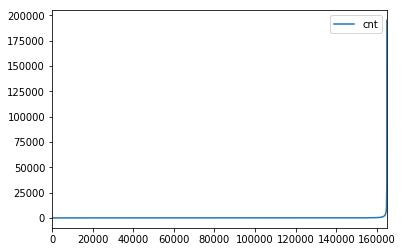

In [24]:
df.sort_values('cnt').reset_index(drop=True).plot()

## Not Drop Rows

### Estimate Value: trade rate

In [25]:
def div_cnt(cnt: int, total_cnt: int) -> float:
    return cnt/total_cnt
totalcnt_byr_df = df.groupby('byr').agg('sum')
df['div_cnt'] = df.apply(lambda x: div_cnt(x.cnt, totalcnt_byr_df.loc[x.byr].cnt), axis=1)

In [28]:
df_rate = df.loc[:, ['byr', 'spl', 'div_cnt']]
df_rate.head()

,byr,spl,div_cnt
0,YP무역,B. S무역,0.026316
1,YP무역,DB무역,0.026316
2,YP무역,K1 TRADING,0.026316
3,YP무역,S무역,0.026316
4,YP무역,미소무역,0.026316


In [29]:
print('max', df_rate.div_cnt.max(), 'min', df_rate.div_cnt.min())

max 1.0 min 6.611141889649464e-07


In [30]:
reader = Reader(rating_scale=(0.0,1.0))
data = Dataset.load_from_df(df_rate, reader)

In [33]:
from surprise.model_selection import cross_validate
from surprise import SVD
from surprise import SVDpp
from surprise import SlopeOne
from surprise import NMF
from surprise import NormalPredictor
from surprise import KNNBaseline
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import BaselineOnly
from surprise import CoClustering

benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), BaselineOnly()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


,fit_time,test_rmse,test_time
Algorithm,,,
BaselineOnly,0.440898,0.253350,0.276661
SVD,4.791285,0.259078,0.349685


### Estimate Value: rating

In [34]:
rating_rate = {1: 0.17, 2: 0.32, 3: 0.45, 4: 0.56, 5: 0.66,
               6: 0.76, 7: 0.85, 8: 0.92, 9: 0.97, 10: 1}
rating = dict()
prev = 0
cumsum_df = df.groupby('cnt').agg('size').cumsum()
total_sum = df.groupby('cnt').agg('size').sum()
for i in rating_rate:
    val = cumsum_df.loc[cumsum_df >= rating_rate[i]*total_sum].index[0]
    rating[i] = [prev+1, val]
    prev = val
print(rating)

{1: [1, 1], 2: [2, 2], 3: [3, 3], 4: [4, 5], 5: [6, 8], 6: [9, 14], 7: [15, 29], 8: [30, 75], 9: [76, 323], 10: [324, 194990]}


In [35]:
for i in rating:
    df.loc[(df.cnt >= rating[i][0]) & (df.cnt <= rating[i][1]), 'rating'] = i

In [38]:
df_rate = df.loc[:, ['byr', 'spl', 'rating']]

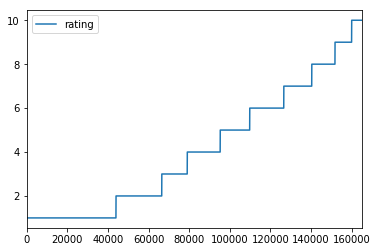

In [39]:
df_rate.sort_values('rating').reset_index(drop=True).plot()

In [40]:
reader = Reader(rating_scale=(1,10))
data = Dataset.load_from_df(df_rate, reader)

In [41]:
from surprise.model_selection import cross_validate
from surprise import SVD
from surprise import KNNBaseline
from surprise import BaselineOnly

benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), KNNBaseline(), BaselineOnly()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')   

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


,fit_time,test_rmse,test_time
Algorithm,,,
SVD,4.781397,2.334102,0.355763
BaselineOnly,0.455912,2.367177,0.297106
KNNBaseline,8.228509,2.470182,0.684070


## Drop Rows

### Estimate Value: trade rate

In [42]:
# Drop rows under 5 evaluations
b = df['byr'].value_counts() >= 5
b = b[b].index.tolist()
df_dropped = df.loc[df['byr'].isin(b)].reset_index(drop=True)

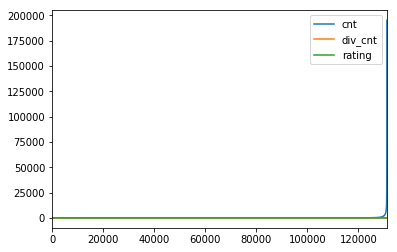

In [46]:
df_dropped.sort_values('cnt').reset_index(drop=True).plot()

In [45]:
def div_cnt(cnt: int, total_cnt: int) -> float:
    return cnt/total_cnt
totalcnt_byr_df = df_dropped.groupby('byr').agg('sum')
df_dropped['div_cnt'] = df_dropped.apply(lambda x: div_cnt(x.cnt, totalcnt_byr_df.loc[x.byr].cnt), axis=1)

In [47]:
df_dropped.head()

,byr,spl,cnt,div_cnt,rating
0,YP무역,B. S무역,1,0.026316,1.0
1,YP무역,DB무역,1,0.026316,1.0
2,YP무역,K1 TRADING,1,0.026316,1.0
3,YP무역,S무역,1,0.026316,1.0
4,YP무역,미소무역,1,0.026316,1.0
